# Large Dataset Training

In [1]:
import os
import json
from stelaro.data import synthetic

DATA_DIRECTORY = "../data/"
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
DATASET_V1_DIRECTORY = DATA_DIRECTORY + "version_1/"
DATASET_V1_COMPRESSED_DIRECTORY = DATASET_V1_DIRECTORY + "compressed/"


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


mkdir(DATA_DIRECTORY)
mkdir(DATASET_V1_DIRECTORY)
mkdir(DATASET_V1_COMPRESSED_DIRECTORY)

## 1. Compress The Dataset

In [3]:
LENGTH = 1500
with open("../datasets/version_1_splits/map.json", "r") as f:
    index_to_taxonomic_label = json.load(f)

for dataset_name in ("validate", "test", "train"):
    with open(f"../datasets/version_1_splits/{dataset_name}.json", "r") as f:
        dataset = json.load(f)
    index_to_n_passes = {}
    directory = DATASET_V1_COMPRESSED_DIRECTORY + dataset_name + "/"
    mkdir(directory)
    synthetic.compress_dataset(
        dataset,
        index_to_taxonomic_label,
        "../data/version_1/genomes/",
        LENGTH,
        directory
    )

100%|██████████| 27/27 [41:05<00:00, 91.32s/it] 


## 2. Sample Data

In [2]:
f = synthetic.get_n_reads_in_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
)
print(f)
n = sum(f)
ids = synthetic.get_random_identifiers(n)

[ 12643  22777  34943  31102  60816   4144  64119  86229   5006  25801
   5386   8599  29738  22694  37733  15253  58687 118124  85929 137871
  79875 149174  21096  75607  16687   1920    346]


In [3]:
from numpy import bincount
x, y = synthetic.sample_compressed_dataset(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
    200_000,
    1500,
    ids,
    400000
)
print(bincount(y))
print(sum(bincount(y)))

[ 2091  3754  5830  5052 10021   647 10467 14440   800  4357   888  1434
  4802  3723  6316  2519  9638 19468 14160 22791 13193 24595  3484 12415
  2733   330    52]
200000


In [ ]:
import numpy as np
from random import shuffle


def get_floored_random_identifiers(directory: str, floor: int, n: int) -> dict:
    """Same as `get_random_identifiers`, but generates identifiers that
    include all elements of a class if its count is low.
    """
    assert floor > 1, "Invalid floor."
    # Determine the number of samples for each class.
    total_reads = synthetic.get_n_reads_in_compressed_dataset(directory)
    counts_to_fetch = {}
    for i, n_reads in enumerate(total_reads):
        if n_reads < floor:
            counts_to_fetch[i] = int(n_reads)
        else:
            counts_to_fetch[i] = 0
    n_remaining = n - sum(counts_to_fetch.values())
    n_remaining_classes = len([0 for _, v in counts_to_fetch.items() if v == 0])
    average = n_remaining / n_remaining_classes
    for i, n_reads in enumerate(total_reads):
        if counts_to_fetch[i] == 0:
            counts_to_fetch[i] = int(average)
            if average > n_reads:
                raise RuntimeError(f"Insufficient number of reads. Required: {average}. Available: {n_reads}.")
    # Obtain sample indices.
    assert directory.endswith("/")
    with open(directory + "counts.json", "r") as file:
        counts = json.load(file)
    identifiers = {k: [] for k in counts_to_fetch}
    global_index = 0
    for identifier, count in counts.items():
        partial_y = np.load(directory + str(identifier) + "_y.npy")
        partial_y = partial_y[:count]
        for i in range(len(partial_y)):
            identifiers[partial_y[i]].append(global_index)
            global_index += 1
    # Reduce the number of samples.
    indices = []
    for i in range(len(identifiers)):
        shuffle(identifiers[i])
        indices += identifiers[i][:counts_to_fetch[i]]
    shuffle(indices)
    identifiers = {}
    for i, v in enumerate(indices):
        identifiers[i] = v
    return identifiers


indices = get_floored_random_identifiers(
    DATASET_V1_COMPRESSED_DIRECTORY + "test/",
    1000,
    50_000
)

{0: 1069153, 1: 342594, 2: 1109940, 3: 1199448, 4: 3540, 5: 1111912, 6: 417384, 7: 690975, 8: 491436, 9: 355662}


In [14]:
with open(f"../datasets/version_1_splits/train.json", "r") as f:
    dataset = json.load(f)


taxon = dataset[-1]
print(taxon[0])
references = []
for element in taxon[1]:
    genus, ref = element
    references += ref
print(synthetic.evaluate_n_nucleotides(references))


['Viruses', 'Monodnaviria']
5158834


In [7]:
import numpy as np
x = np.load(DATASET_V1_COMPRESSED_DIRECTORY + "train/0_x.npy")
print(x.shape)

(1000000, 375)


## 3. Train Neural Networks

In [2]:
from stelaro import models
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from stelaro.models import feedforward, autoencoder, transformer
from time import time

LENGTH = 1500
BATCH_SIZE = 128
N_SAMPLE_BETWEEN_INTERVALS = 50_000

train_data = DataLoader(
    synthetic.CompressedReadDataset(
        "../data/version_1/compressed/train/", N_SAMPLE_BETWEEN_INTERVALS, 10
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
validate_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/validate/", 50_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_data = DataLoader(
    synthetic.SyntheticReadDataset(
        "../data/version_1/compressed/test/", 100_000, LENGTH, 2000
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

with open("../datasets/version_1_splits/map.json", "r") as f:
    mapping = json.load(f)


def benchmark(classifier: models.BaseClassifier, name: str, n_max_reads, patience=4):
    train_data.dataset.reset()
    parameters = classifier.get_parameters()
    if parameters:
        optimizer = Adam(classifier.get_parameters(), lr=0.001)
        total_params = sum(param.numel() for param in parameters)
        print(f"Number of parameters: {total_params:_}")
    else:
        optimizer = None
    a = time()
    losses, f1 = classifier.train_large_dataset(
        train_data,
        validate_data,
        optimizer,
        evaluation_interval=N_SAMPLE_BETWEEN_INTERVALS,
        n_max_reads=n_max_reads,
        patience=patience,
    )
    b = time()
    print(f"Training took {(b - a):.3f} s.")
    if losses:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        x = list(range(len(losses)))
        ax[0].plot(x, losses, label="losses")
        ax[0].set(xlabel='Epochs', ylabel='Loss')
        ax[0].set_title("Loss")
        ax[1].set(xlabel='Epochs', ylabel="f1")
        ax[1].set_title("F1 Score")
        r = 0
        for f in f1:
            ax[1].plot(x, f, label=f'Rank {r}')
            r += 1
        ax[1].legend()
        fig.suptitle(f"Classification Training for {name}")
        plt.show()
    result = models.evaluate(classifier, test_data, "cuda", mapping, permute=False)
    rounded_result = [float(f"{r:.5}") for r in result]
    print(f"Test results: {rounded_result}")
    return classifier


from torch import no_grad, float32
import numpy as np


def confusion_matrix(classifier, loader, device, mapping) -> np.ndarray:
    """Returns: A confusion matrix with rows corresponding to true labels."""
    matrix = np.zeros((len(mapping), len(mapping)))
    with no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.type(float32).to(device)
            #x_batch = x_batch.permute(0, 2, 1)  # Swap channels and sequence.
            y_batch = y_batch.to("cpu")
            predictions = classifier.predict(x_batch)
            for y, p in zip(y_batch, predictions):
                matrix[y][p] += 1
    return matrix

### 3.1. Baseline

In [ ]:
model = benchmark(
    models.RandomClassifier(),
    "Random Classifier",
    n_max_reads=30_000
)
model.n_classes = len(mapping)

  0%|          | 234/68609 [00:00<03:01, 377.43it/s]


Training took 0.622 s.
Test results: [0.32995, 0.032383]


{'0': ['Archaea', 'Thermoproteota'], '1': ['Archaea', 'Halobacteriota'], '2': ['Archaea', 'Methanobacteriota'], '3': ['Bacteria', 'Acidobacteriota'], '4': ['Bacteria', 'Desulfobacterota'], '5': ['Bacteria', 'Aquificota'], '6': ['Bacteria', 'Planctomycetota'], '7': ['Bacteria', 'Myxococcota'], '8': ['Bacteria', 'Synergistota'], '9': ['Bacteria', 'Chloroflexota'], '10': ['Bacteria', 'Thermotogota'], '11': ['Bacteria', 'Deinococcota'], '12': ['Bacteria', 'Cyanobacteriota'], '13': ['Bacteria', 'Bacteroidota_A'], '14': ['Bacteria', 'Fusobacteriota'], '15': ['Bacteria', 'Chlamydiota'], '16': ['Bacteria', 'Spirochaetota'], '17': ['Bacteria', 'Desulfobacterota_I'], '18': ['Bacteria', 'Verrucomicrobiota'], '19': ['Bacteria', 'Bacteroidota'], '20': ['Bacteria', 'Campylobacterota'], '21': ['Bacteria', 'Actinomycetota'], '22': ['Bacteria', 'Bacillota'], '23': ['Bacteria', 'Pseudomonadota'], '24': ['Viruses', 'Duplodnaviria'], '25': ['Viruses', 'Riboviria'], '26': ['Viruses', 'Monodnaviria']}


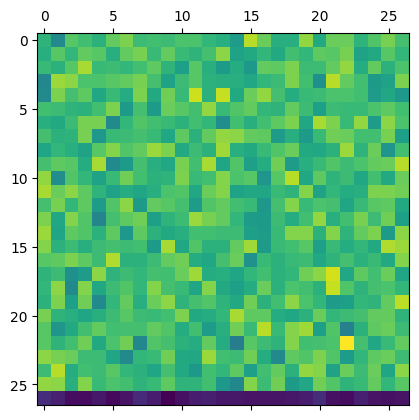

In [ ]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()

In [7]:
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)
print(np.sum(matrix))
print(np.sum(matrix, axis=0))
print(np.sum(matrix, axis=1))

[[67. 51. 75. 71. 66. 77. 81. 70. 71. 70. 73. 73. 68. 65. 58. 89. 78. 65. 65. 84. 63. 78. 78. 67. 74. 80. 72.]
 [65. 75. 68. 77. 75. 65. 77. 80. 69. 77. 69. 67. 72. 83. 60. 63. 68. 63. 71. 68. 76. 75. 80. 60. 63. 75. 68.]
 [69. 66. 75. 87. 69. 70. 68. 71. 76. 67. 59. 75. 65. 57. 64. 56. 77. 76. 81. 70. 70. 77. 84. 64. 77. 66. 73.]
 [50. 85. 83. 73. 73. 75. 77. 80. 72. 60. 70. 75. 66. 65. 65. 62. 68. 70. 81. 71. 53. 89. 77. 71. 57. 60. 81.]
 [51. 81. 72. 76. 62. 69. 64. 81. 63. 79. 69. 92. 66. 91. 63. 78. 84. 72. 64. 69. 70. 73. 73. 71. 58. 62. 56.]
 [71. 70. 67. 66. 71. 81. 57. 72. 57. 78. 75. 71. 84. 69. 74. 77. 68. 67. 77. 70. 59. 70. 69. 69. 73. 76. 71.]
 [65. 63. 70. 80. 80. 51. 68. 74. 71. 69. 66. 71. 68. 52. 71. 65. 71. 76. 81. 62. 87. 81. 69. 84. 58. 83. 73.]
 [72. 66. 67. 80. 56. 69. 70. 72. 69. 62. 76. 66. 77. 84. 83. 77. 76. 58. 65. 57. 69. 79. 78. 71. 71. 80. 59.]
 [61. 68. 65. 60. 75. 82. 74. 77. 85. 81. 63. 70. 66. 86. 65. 63. 69. 74. 78. 63. 62. 66. 85. 67. 78. 55. 71.]
 

### 3.2. CNN

Number of parameters: 35_967_670


  1%|          | 396/68609 [00:19<5:50:06,  3.25it/s]

N Reads: 50048 Loss: 1010.50. F1: [0.30475, 0.053738]. Patience: 4


  1%|          | 784/68609 [00:40<9:59:53,  1.88it/s]

N Reads: 100096 Loss: 879.38. F1: [0.38529, 0.093334]. Patience: 4


  2%|▏         | 1177/68609 [01:02<6:47:38,  2.76it/s]

N Reads: 150144 Loss: 803.85. F1: [0.40049, 0.14599]. Patience: 4


  2%|▏         | 1567/68609 [01:26<8:25:37,  2.21it/s] 

N Reads: 200192 Loss: 761.68. F1: [0.36856, 0.1783]. Patience: 4


  3%|▎         | 1957/68609 [01:47<8:56:13,  2.07it/s]

N Reads: 250240 Loss: 714.40. F1: [0.40692, 0.17854]. Patience: 4


  3%|▎         | 2351/68609 [02:12<8:02:39,  2.29it/s] 

N Reads: 300288 Loss: 685.20. F1: [0.41042, 0.19531]. Patience: 4


  4%|▍         | 2742/68609 [02:34<6:34:21,  2.78it/s]

N Reads: 350336 Loss: 663.34. F1: [0.41068, 0.19997]. Patience: 4


  5%|▍         | 3133/68609 [02:58<8:01:38,  2.27it/s] 

N Reads: 400384 Loss: 643.00. F1: [0.39821, 0.21228]. Patience: 4


  5%|▌         | 3524/68609 [03:21<6:13:26,  2.90it/s]

N Reads: 450432 Loss: 628.73. F1: [0.4019, 0.22195]. Patience: 4


  6%|▌         | 3914/68609 [03:45<7:58:11,  2.25it/s] 

N Reads: 500480 Loss: 615.22. F1: [0.42855, 0.24757]. Patience: 4


  6%|▋         | 4303/68609 [04:07<8:11:16,  2.18it/s]

N Reads: 550528 Loss: 601.61. F1: [0.42689, 0.25745]. Patience: 4


  7%|▋         | 4694/68609 [04:32<10:59:32,  1.62it/s]

N Reads: 600576 Loss: 593.42. F1: [0.44568, 0.26412]. Patience: 4


  7%|▋         | 5085/68609 [04:55<8:28:37,  2.08it/s] 

N Reads: 650624 Loss: 583.25. F1: [0.43684, 0.28328]. Patience: 4


  8%|▊         | 5478/68609 [05:21<7:57:48,  2.20it/s] 

N Reads: 700672 Loss: 579.03. F1: [0.46303, 0.24641]. Patience: 3


  9%|▊         | 5867/68609 [05:45<8:35:37,  2.03it/s]

N Reads: 750720 Loss: 566.52. F1: [0.4374, 0.29428]. Patience: 3


  9%|▉         | 6261/68609 [06:11<8:10:37,  2.12it/s] 

N Reads: 800768 Loss: 562.48. F1: [0.47543, 0.29603]. Patience: 3


 10%|▉         | 6651/68609 [06:35<6:13:21,  2.77it/s]

N Reads: 850816 Loss: 555.06. F1: [0.46326, 0.26431]. Patience: 2


 10%|█         | 7042/68609 [07:02<8:08:56,  2.10it/s] 

N Reads: 900864 Loss: 558.89. F1: [0.51249, 0.28875]. Patience: 1


 11%|█         | 7432/68609 [07:26<8:21:03,  2.03it/s]

N Reads: 950912 Loss: 546.36. F1: [0.4639, 0.29811]. Patience: 1


 11%|█▏        | 7824/68609 [07:53<8:25:21,  2.00it/s] 

N Reads: 1000960 Loss: 542.37. F1: [0.49557, 0.31291]. Patience: 1


 12%|█▏        | 8210/68609 [08:18<1:01:06, 16.47it/s]

N Reads: 1051008 Loss: 535.93. F1: [0.48375, 0.31049]. Patience: 0
The model is overfitting; stopping early.
Processed 1_051_008 reads.
Training took 498.417 s.


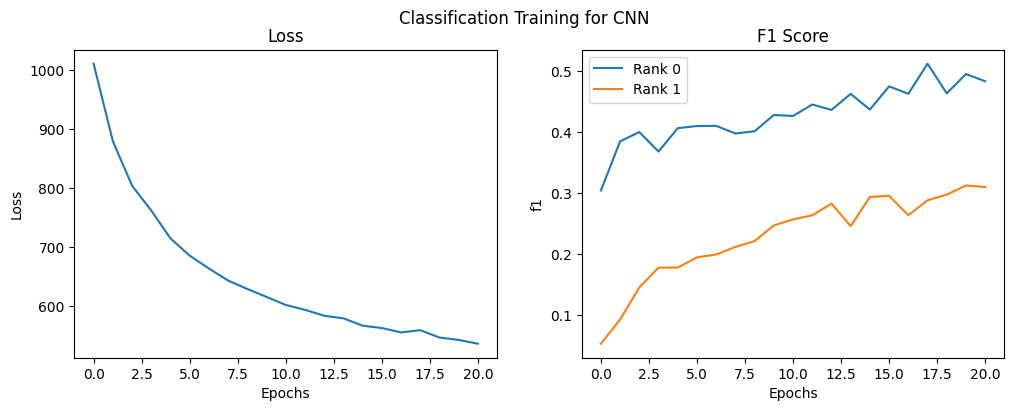

Test results: [0.5222, 0.32266]


In [11]:
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class CNN_2_dropout_token(Module):
    def __init__(self, N, M):
        super(CNN_2_dropout_token, self).__init__()
        self.conv = Sequential(
            Conv1d(4, 32, kernel_size=7, padding=3),
            ReLU(),
            Conv1d(32, 64, kernel_size=5, padding=2),
            ReLU(),
            Conv1d(64, 128, kernel_size=3, padding=1),
            ReLU(),
        )
        n = N * 4
        self.fc = Sequential(
            Flatten(),
            Dropout(0.2),
            Linear(n * 128, int(n / 8)),
            ReLU(),
            Dropout(0.2),
            Linear(int(n / 8), 128),
            ReLU(),
            Dropout(0.2),
            Linear(128, M)
        )

    def forward(self, x):
        B, N = x.shape
        shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
        x_expanded = x.unsqueeze(-1).to(int)
        tokens = (x_expanded >> shifts) & 0b11
        tokens = tokens.view(B, N * 4)
        one_hot = F.one_hot(tokens, num_classes=4).float()
        x = one_hot.permute(0, 2, 1)
        x = self.conv(x)
        x = self.fc(x)
        return x.to(float)


model = benchmark(
    feedforward.Classifier(LENGTH // 4, mapping, "cuda", CNN_2_dropout_token),
    "CNN",
    n_max_reads=1_200_000
)

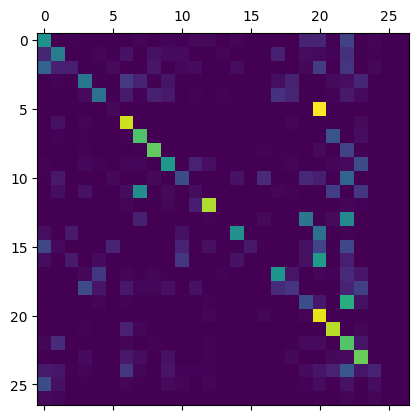

[[1909.    8.   35.    2.    0.    0.    0.   46.    9.   56.   40.   94.   82.    0.   67.    3.    4.    0.    0.  353.  388.   21.  730.    1.   70.    0.    0.]
 [ 391. 1593.   10.    6.   63.   21.  183.    3.  172.  108.  113.   13.    2.   58.    3.    2.   22.  325.    9.  124.   81.   35.  518.   24.   30.    0.    0.]
 [1188.  325.  319.    0.   15.   93.    0.    0.  230.    0.   76.  112.    2.    0.  121.    0.   11.    0.    0.   87.  673.    0.  582.    0.   75.    0.    0.]
 [   1.   35.    0. 1467.   24.    0.  618.  366.   24.  219.    5.   19.    5.   11.    0.    0.    0.  140.  349.    2.    1.   88.  142.  391.    2.    0.    0.]
 [   2.   27.    0.  100. 1417.    0.  276.   33.  334.  258.    3.   35.    8.   43.    0.    0.   25.  536.  392.   16.    3.   38.  257.  104.    2.    0.    0.]
 [  20.    3.    1.    0.    0.   81.    0.    0.    0.    4.    6.    8.    8.    0.    9.    0.    2.    0.    1.    8. 3753.    0.    5.    0.    0.    0.    0.]
 [   0.  1

In [13]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.3. Transformer

Number of parameters: 1_075_611


  0%|          | 157/68609 [01:28<203:32:08, 10.70s/it]

N Reads: 20096 Loss: 404.13. F1: [0.31579, 0.051469]. Patience: 10


  0%|          | 314/68609 [02:58<212:30:58, 11.20s/it]

N Reads: 40192 Loss: 359.25. F1: [0.31775, 0.078612]. Patience: 10


  1%|          | 471/68609 [04:30<212:30:24, 11.23s/it]

N Reads: 60288 Loss: 343.64. F1: [0.35996, 0.089922]. Patience: 10


  1%|          | 628/68609 [06:03<217:37:01, 11.52s/it]

N Reads: 80384 Loss: 323.77. F1: [0.33139, 0.15055]. Patience: 10


  1%|          | 785/68609 [07:39<220:16:25, 11.69s/it]

N Reads: 100480 Loss: 306.14. F1: [0.38888, 0.18928]. Patience: 10


  1%|▏         | 942/68609 [09:15<219:57:47, 11.70s/it]

N Reads: 120576 Loss: 287.08. F1: [0.40941, 0.19905]. Patience: 10


  2%|▏         | 1099/68609 [10:50<217:21:24, 11.59s/it]

N Reads: 140672 Loss: 275.99. F1: [0.40704, 0.19325]. Patience: 9


  2%|▏         | 1256/68609 [12:27<218:26:22, 11.68s/it]

N Reads: 160768 Loss: 267.72. F1: [0.4536, 0.20585]. Patience: 9


  2%|▏         | 1413/68609 [14:04<221:06:52, 11.85s/it]

N Reads: 180864 Loss: 260.60. F1: [0.42375, 0.21545]. Patience: 9


  2%|▏         | 1570/68609 [15:42<219:09:48, 11.77s/it]

N Reads: 200960 Loss: 259.53. F1: [0.40978, 0.22513]. Patience: 9


  3%|▎         | 1727/68609 [17:19<217:03:43, 11.68s/it]

N Reads: 221056 Loss: 252.04. F1: [0.48716, 0.2378]. Patience: 9


  3%|▎         | 1884/68609 [18:56<218:14:22, 11.77s/it]

N Reads: 241152 Loss: 249.33. F1: [0.46153, 0.23121]. Patience: 8


  3%|▎         | 2041/68609 [20:33<215:24:48, 11.65s/it]

N Reads: 261248 Loss: 245.01. F1: [0.46278, 0.24806]. Patience: 8


  3%|▎         | 2198/68609 [22:10<215:49:10, 11.70s/it]

N Reads: 281344 Loss: 237.04. F1: [0.47312, 0.25646]. Patience: 8


  3%|▎         | 2355/68609 [23:46<215:19:18, 11.70s/it]

N Reads: 301440 Loss: 232.29. F1: [0.48491, 0.26555]. Patience: 8


  4%|▎         | 2512/68609 [25:23<213:56:17, 11.65s/it]

N Reads: 321536 Loss: 231.07. F1: [0.44724, 0.25296]. Patience: 7


  4%|▍         | 2669/68609 [26:59<212:26:58, 11.60s/it]

N Reads: 341632 Loss: 229.23. F1: [0.4391, 0.29332]. Patience: 7


  4%|▍         | 2826/68609 [28:36<214:12:46, 11.72s/it]

N Reads: 361728 Loss: 224.37. F1: [0.44442, 0.26611]. Patience: 6


  4%|▍         | 2983/68609 [30:13<212:06:13, 11.64s/it]

N Reads: 381824 Loss: 222.79. F1: [0.46558, 0.29723]. Patience: 6


  5%|▍         | 3140/68609 [31:51<214:33:24, 11.80s/it]

N Reads: 401920 Loss: 219.28. F1: [0.47442, 0.27038]. Patience: 5


  5%|▍         | 3297/68609 [33:28<213:24:06, 11.76s/it]

N Reads: 422016 Loss: 213.76. F1: [0.48484, 0.28662]. Patience: 4


  5%|▌         | 3454/68609 [35:05<212:05:03, 11.72s/it]

N Reads: 442112 Loss: 214.90. F1: [0.49246, 0.2809]. Patience: 3


  5%|▌         | 3611/68609 [36:43<212:07:17, 11.75s/it]

N Reads: 462208 Loss: 212.42. F1: [0.47776, 0.29095]. Patience: 2


  5%|▌         | 3768/68609 [38:22<211:01:53, 11.72s/it]

N Reads: 482304 Loss: 208.47. F1: [0.574, 0.31379]. Patience: 2


  6%|▌         | 3925/68609 [39:59<211:33:51, 11.77s/it]

N Reads: 502400 Loss: 205.24. F1: [0.5391, 0.29787]. Patience: 1


  6%|▌         | 4082/68609 [41:38<211:30:02, 11.80s/it]

N Reads: 522496 Loss: 204.17. F1: [0.55221, 0.3208]. Patience: 1


  6%|▌         | 4238/68609 [43:15<10:57:05,  1.63it/s] 

N Reads: 542592 Loss: 202.96. F1: [0.50541, 0.31829]. Patience: 0
The model is overfitting; stopping early.
Processed 542_592 reads.
Training took 2595.659 s.


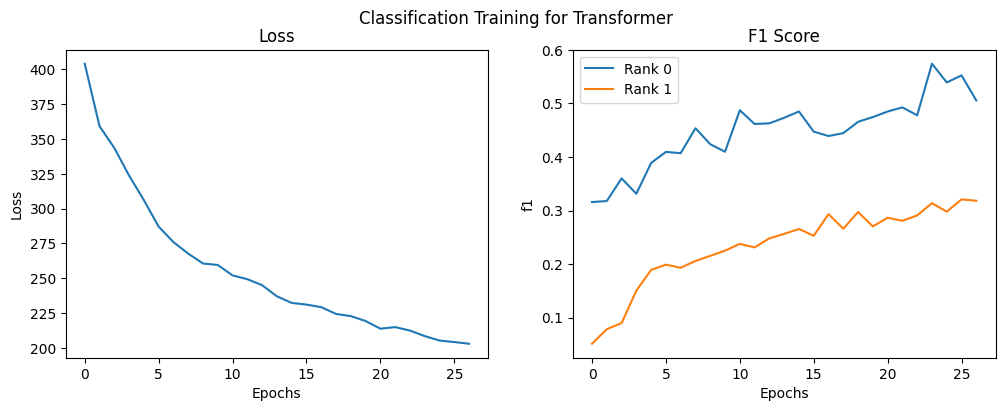

Test results: [0.55535, 0.33642]


d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


In [9]:
from torch import exp as torch_exp, randn, arange
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, MSELoss, MaxPool1d, ConvTranspose1d,
                      Sigmoid, LeakyReLU, functional, Parameter, Embedding,
                      TransformerEncoderLayer, TransformerEncoder, Dropout)


class T_1_tokens(Module):
    def __init__(self, N, M):
        super(T_1_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=5)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_1_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=1_500_000,
    patience=10,
)

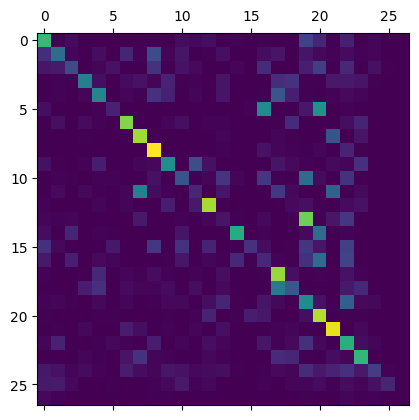

[[2132.   20.   99.    0.    0.    0.    2.   13.    4.    3.  103.   72.  116.    1.   30.   10.   13.    0.    2.  612.  329.   19.  278.    5.   50.    5.    0.]
 [ 420. 1119.   42.    2.  109.   10.  333.   27.  727.   57.  183.    9.   13.  127.    3.    2.  103.  172.    5.  176.   66.   31.   98.   33.   41.    1.    0.]
 [ 190.  233.  730.    0.   60.  155.    0.    0.  456.    9.  153.   81.    6.    1.   58.    1.  384.    2.    0.  272.  591.    0.  365.    2.  147.   13.    0.]
 [  12.   29.    0. 1355.  124.    0.   92.  155.   55.  320.   14.   35.    7.  172.    0.    0.    0.  421.  452.   15.   13.  222.  218.  183.   15.    0.    0.]
 [   3.   29.    1.   54. 1446.    0.   56.   19.  456.  283.    9.   51.    9.  183.    0.    0.   19.  835.  265.   19.   11.   34.   79.   45.    3.    0.    0.]
 [ 114.    1.    3.    0.   37.  293.    0.    0.    3.    0.   10.    0.    5.    0.   10.   25. 1528.    0.    0.  207. 1627.    0.   37.    8.    1.    0.    0.]
 [   0.  1

In [10]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

Number of parameters: 480_795


  0%|          | 158/68609 [00:52<105:23:46,  5.54s/it]

N Reads: 20096 Loss: 394.84. F1: [0.31704, 0.097116]. Patience: 4


  0%|          | 315/68609 [01:47<111:22:42,  5.87s/it]

N Reads: 40192 Loss: 321.59. F1: [0.36969, 0.15643]. Patience: 4


  1%|          | 472/68609 [02:44<111:53:30,  5.91s/it]

N Reads: 60288 Loss: 295.24. F1: [0.39478, 0.1828]. Patience: 4


  1%|          | 628/68609 [03:41<159:45:52,  8.46s/it]

N Reads: 80384 Loss: 271.60. F1: [0.44995, 0.21787]. Patience: 4


  1%|          | 786/68609 [04:38<110:45:14,  5.88s/it]

N Reads: 100480 Loss: 258.38. F1: [0.44252, 0.22529]. Patience: 4


  1%|▏         | 943/68609 [06:02<133:37:56,  7.11s/it]

N Reads: 120576 Loss: 247.56. F1: [0.48088, 0.24671]. Patience: 4


  2%|▏         | 1099/68609 [06:58<152:39:51,  8.14s/it]

N Reads: 140672 Loss: 242.45. F1: [0.4855, 0.26097]. Patience: 4


  2%|▏         | 1257/68609 [07:55<108:24:39,  5.79s/it]

N Reads: 160768 Loss: 235.73. F1: [0.48084, 0.24493]. Patience: 3


  2%|▏         | 1414/68609 [08:51<106:17:30,  5.69s/it]

N Reads: 180864 Loss: 231.72. F1: [0.44988, 0.25784]. Patience: 2


  2%|▏         | 1571/68609 [09:46<105:43:15,  5.68s/it]

N Reads: 200960 Loss: 231.95. F1: [0.4724, 0.2879]. Patience: 2


  3%|▎         | 1728/68609 [10:42<106:08:00,  5.71s/it]

N Reads: 221056 Loss: 223.32. F1: [0.51902, 0.29634]. Patience: 2


  3%|▎         | 1885/68609 [11:39<106:25:20,  5.74s/it]

N Reads: 241152 Loss: 220.22. F1: [0.49958, 0.29251]. Patience: 1


  3%|▎         | 2040/68609 [12:35<6:50:44,  2.70it/s]  

N Reads: 261248 Loss: 217.81. F1: [0.45677, 0.27887]. Patience: 0
The model is overfitting; stopping early.
Processed 261_248 reads.
Training took 755.235 s.


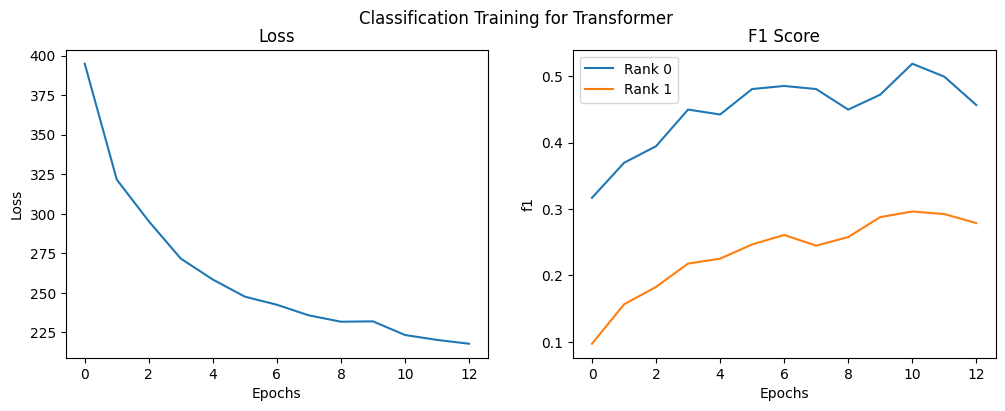

Test results: [0.49432, 0.29287]


d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
d:\maitrise\stelaro\venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)


In [16]:
class T_2_tokens(Module):
    def __init__(self, N, M):
        super(T_2_tokens, self).__init__()
        embed_dim = 128
        self.token_embedding = Embedding(256, embed_dim)
        self.position_embedding = Embedding(N, embed_dim)
        encoder_layer = TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=8,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='relu',
            batch_first=True  # makes input/output shape [B, L, D]
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=2)
        self.classifier = Linear(embed_dim, M)

    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        x = self.token_embedding(x) + self.position_embedding(positions)  # [B, L, D]
        x = self.transformer_encoder(x)  # [B, L, D]
        x = x.mean(dim=1)  # [B, D] - average pooling
        logits = self.classifier(x)  # [B, num_classes]
        return logits


model = benchmark(
    transformer.Classifier(LENGTH // 4, mapping, "cuda", T_2_tokens, use_tokens=True),
    "Transformer",
    n_max_reads=1_200_000
)

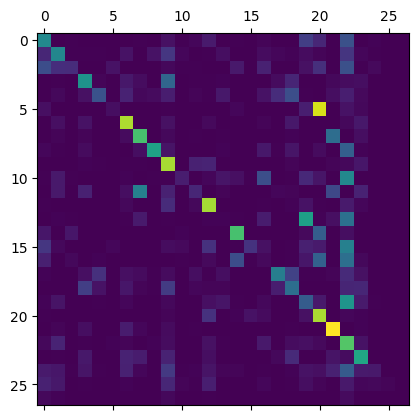

[[1546.    5.   18.    0.    0.    0.    0.   21.    1.  152.   18.   59.  233.    0.   23.    5.   43.    0.    1.  599.  344.    9.  809.    3.   29.    0.    0.]
 [ 346. 1504.   18.   20.   25.    5.  158.   10.  160.  511.   56.    6.   15.  122.    6.    3.  104.   58.   27.  112.   48.   11.  507.   53.   22.    2.    0.]
 [ 774.  431.  415.    0.    0.  155.    0.    0.    6.   68.   24.   18.    9.    0.  224.    5.  295.    0.    5.  141.  435.    0.  798.   21.   85.    0.    0.]
 [   2.   18.    0. 1671.   43.    0.  211.  108.    2. 1066.    0.   17.   13.   28.    0.    0.    1.   89.  337.    6.    5.   64.  106.  117.    5.    0.    0.]
 [   4.   64.    0.  152.  824.    0.  309.   75.   93.  256.    1.   50.   25.  204.    0.    1.  162.  414.  775.   13.    9.  117.  272.   87.    2.    0.    0.]
 [ 135.    5.    0.    0.    0.  115.    0.    0.    0.   16.    1.    1.    9.    0.   60.   12.    9.    0.    0.  272. 3048.    0.  160.   66.    0.    0.    0.]
 [   1.  1

In [18]:
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)

### 3.4. Autoencoders

Number of parameters: 73_427_257


  1%|          | 395/68609 [00:27<7:44:38,  2.45it/s] 

N Reads: 50048 Loss: 314.75. F1: [0.35615, 0.070641]. Patience: 30


  1%|          | 787/68609 [00:48<9:50:22,  1.91it/s] 

N Reads: 100096 Loss: 281.67. F1: [0.40199, 0.11616]. Patience: 30


  2%|▏         | 1177/68609 [01:09<10:09:29,  1.84it/s]

N Reads: 150144 Loss: 264.40. F1: [0.47945, 0.14751]. Patience: 30


  2%|▏         | 1566/68609 [01:30<13:12:24,  1.41it/s]

N Reads: 200192 Loss: 245.43. F1: [0.49689, 0.20127]. Patience: 30


  3%|▎         | 1957/68609 [01:51<13:10:09,  1.41it/s]

N Reads: 250240 Loss: 234.45. F1: [0.41366, 0.20009]. Patience: 29


  3%|▎         | 2350/68609 [02:13<9:51:29,  1.87it/s] 

N Reads: 300288 Loss: 226.84. F1: [0.43025, 0.23759]. Patience: 29


  4%|▍         | 2740/68609 [02:34<10:42:38,  1.71it/s]

N Reads: 350336 Loss: 221.63. F1: [0.50459, 0.25269]. Patience: 29


  5%|▍         | 3132/68609 [02:56<10:58:47,  1.66it/s]

N Reads: 400384 Loss: 217.29. F1: [0.44896, 0.26531]. Patience: 29


  5%|▌         | 3523/68609 [03:18<10:28:57,  1.72it/s]

N Reads: 450432 Loss: 213.08. F1: [0.51503, 0.27383]. Patience: 29


  6%|▌         | 3912/68609 [03:40<13:45:05,  1.31it/s]

N Reads: 500480 Loss: 209.25. F1: [0.52694, 0.27584]. Patience: 29


  6%|▋         | 4304/68609 [04:02<10:13:40,  1.75it/s]

N Reads: 550528 Loss: 206.04. F1: [0.50893, 0.29217]. Patience: 29


  7%|▋         | 4695/68609 [04:24<9:43:11,  1.83it/s] 

N Reads: 600576 Loss: 202.98. F1: [0.54184, 0.3127]. Patience: 29


  7%|▋         | 5087/68609 [04:45<9:16:21,  1.90it/s] 

N Reads: 650624 Loss: 200.85. F1: [0.50163, 0.2967]. Patience: 28


  8%|▊         | 5478/68609 [05:08<9:10:50,  1.91it/s] 

N Reads: 700672 Loss: 198.46. F1: [0.55178, 0.33589]. Patience: 28


  9%|▊         | 5868/68609 [05:30<9:35:44,  1.82it/s] 

N Reads: 750720 Loss: 195.18. F1: [0.55984, 0.31515]. Patience: 27


  9%|▉         | 6259/68609 [05:52<10:40:47,  1.62it/s]

N Reads: 800768 Loss: 195.12. F1: [0.60989, 0.34755]. Patience: 27


 10%|▉         | 6650/68609 [06:15<10:51:55,  1.58it/s]

N Reads: 850816 Loss: 193.25. F1: [0.62941, 0.37061]. Patience: 27


 10%|█         | 7040/68609 [06:38<13:12:20,  1.30it/s]

N Reads: 900864 Loss: 191.06. F1: [0.56294, 0.33412]. Patience: 26


 11%|█         | 7433/68609 [07:01<9:02:38,  1.88it/s] 

N Reads: 950912 Loss: 190.02. F1: [0.61369, 0.353]. Patience: 25


 11%|█▏        | 7823/68609 [07:24<9:12:41,  1.83it/s] 

N Reads: 1000960 Loss: 187.54. F1: [0.57164, 0.33991]. Patience: 24


 12%|█▏        | 8214/68609 [07:49<11:17:23,  1.49it/s]

N Reads: 1051008 Loss: 186.90. F1: [0.55528, 0.36551]. Patience: 23


 13%|█▎        | 8607/68609 [08:11<7:40:23,  2.17it/s] 

N Reads: 1101056 Loss: 186.61. F1: [0.58116, 0.36923]. Patience: 22


 13%|█▎        | 8997/68609 [08:33<7:34:15,  2.19it/s] 

N Reads: 1151104 Loss: 183.47. F1: [0.63061, 0.39051]. Patience: 22


 14%|█▎        | 9387/68609 [08:56<8:51:50,  1.86it/s] 

N Reads: 1201152 Loss: 183.31. F1: [0.62816, 0.38946]. Patience: 21


 14%|█▍        | 9777/68609 [09:19<11:54:38,  1.37it/s]

N Reads: 1251200 Loss: 183.35. F1: [0.64102, 0.39166]. Patience: 21


 15%|█▍        | 10169/68609 [09:42<8:49:44,  1.84it/s] 

N Reads: 1301248 Loss: 182.03. F1: [0.58628, 0.37172]. Patience: 20


 15%|█▌        | 10561/68609 [10:05<7:30:48,  2.15it/s] 

N Reads: 1351296 Loss: 179.56. F1: [0.64871, 0.40405]. Patience: 20


 16%|█▌        | 10951/68609 [10:28<8:23:18,  1.91it/s] 

N Reads: 1401344 Loss: 179.47. F1: [0.64357, 0.39274]. Patience: 19


 17%|█▋        | 11344/68609 [10:51<7:13:28,  2.20it/s] 

N Reads: 1451392 Loss: 180.00. F1: [0.62574, 0.39921]. Patience: 18


 17%|█▋        | 11734/68609 [11:14<7:38:27,  2.07it/s] 

N Reads: 1501440 Loss: 178.37. F1: [0.61565, 0.41102]. Patience: 18


 18%|█▊        | 12124/68609 [11:38<8:28:44,  1.85it/s] 

N Reads: 1551488 Loss: 175.95. F1: [0.6435, 0.41247]. Patience: 18


 18%|█▊        | 12514/68609 [12:02<11:11:13,  1.39it/s]

N Reads: 1601536 Loss: 175.66. F1: [0.62886, 0.397]. Patience: 17


 19%|█▉        | 12907/68609 [12:26<8:00:49,  1.93it/s] 

N Reads: 1651584 Loss: 175.08. F1: [0.65311, 0.4045]. Patience: 16


 19%|█▉        | 13297/68609 [12:53<9:40:48,  1.59it/s] 

N Reads: 1701632 Loss: 177.00. F1: [0.6614, 0.42409]. Patience: 16


 20%|█▉        | 13689/68609 [13:17<6:46:11,  2.25it/s]

N Reads: 1751680 Loss: 175.12. F1: [0.67439, 0.4127]. Patience: 15


 21%|██        | 14079/68609 [13:40<6:45:29,  2.24it/s]

N Reads: 1801728 Loss: 173.24. F1: [0.67286, 0.4047]. Patience: 14


 21%|██        | 14469/68609 [14:03<9:12:37,  1.63it/s]

N Reads: 1851776 Loss: 172.94. F1: [0.65063, 0.39881]. Patience: 13


 22%|██▏       | 14862/68609 [14:26<6:29:30,  2.30it/s]

N Reads: 1901824 Loss: 171.74. F1: [0.66558, 0.40871]. Patience: 12


 22%|██▏       | 15252/68609 [14:49<6:37:13,  2.24it/s]

N Reads: 1951872 Loss: 171.46. F1: [0.65953, 0.39119]. Patience: 11


 23%|██▎       | 15642/68609 [15:12<8:49:53,  1.67it/s]

N Reads: 2001920 Loss: 169.86. F1: [0.65775, 0.42315]. Patience: 10


 23%|██▎       | 16034/68609 [15:35<6:22:04,  2.29it/s]

N Reads: 2051968 Loss: 170.85. F1: [0.66588, 0.41423]. Patience: 9


 24%|██▍       | 16427/68609 [15:58<6:15:49,  2.31it/s]

N Reads: 2102016 Loss: 170.17. F1: [0.66533, 0.40376]. Patience: 8


 25%|██▍       | 16817/68609 [16:21<6:15:18,  2.30it/s]

N Reads: 2152064 Loss: 168.61. F1: [0.64297, 0.39754]. Patience: 7


 25%|██▌       | 17207/68609 [16:45<6:14:15,  2.29it/s]

N Reads: 2202112 Loss: 168.72. F1: [0.66909, 0.42075]. Patience: 6


 26%|██▌       | 17600/68609 [17:08<6:20:53,  2.23it/s]

N Reads: 2252160 Loss: 168.01. F1: [0.66643, 0.40902]. Patience: 5


 26%|██▌       | 17990/68609 [17:32<6:02:08,  2.33it/s]

N Reads: 2302208 Loss: 167.09. F1: [0.68567, 0.40898]. Patience: 4


 27%|██▋       | 18380/68609 [17:55<6:05:54,  2.29it/s]

N Reads: 2352256 Loss: 166.66. F1: [0.6654, 0.42653]. Patience: 4


 27%|██▋       | 18773/68609 [18:19<5:57:44,  2.32it/s]

N Reads: 2402304 Loss: 164.68. F1: [0.70759, 0.4353]. Patience: 4


 28%|██▊       | 19163/68609 [18:43<5:49:17,  2.36it/s]

N Reads: 2452352 Loss: 165.83. F1: [0.6518, 0.42472]. Patience: 3


 28%|██▊       | 19553/68609 [19:06<5:46:07,  2.36it/s]

N Reads: 2502400 Loss: 165.62. F1: [0.67917, 0.42224]. Patience: 2


 29%|██▉       | 19943/68609 [19:30<7:47:21,  1.74it/s]

N Reads: 2552448 Loss: 164.66. F1: [0.65716, 0.41341]. Patience: 1


 30%|██▉       | 20336/68609 [19:54<5:45:03,  2.33it/s]

N Reads: 2602496 Loss: 164.23. F1: [0.68696, 0.43766]. Patience: 1


 30%|███       | 20726/68609 [20:19<6:26:43,  2.06it/s]

N Reads: 2652544 Loss: 163.55. F1: [0.67588, 0.46205]. Patience: 1


 31%|███       | 21113/68609 [20:46<46:43, 16.94it/s]  

N Reads: 2702592 Loss: 164.43. F1: [0.68181, 0.43344]. Patience: 0
The model is overfitting; stopping early.
Processed 2_702_592 reads.
Training took 1246.218 s.


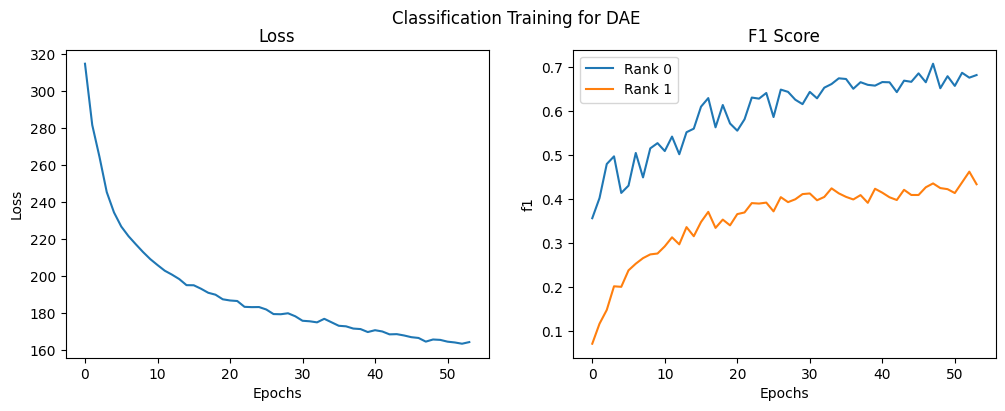

Test results: [0.70319, 0.45316]


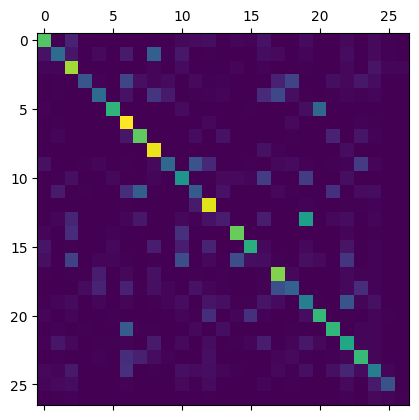

[[2642.    8.  365.    0.    0.    2.    3.    0.    1.    0.   77.   99.  140.    1.   58.   36.  174.    1.    0.  108.    1.    8.   81.    0.   93.   20.    0.]
 [ 176. 1267.  221.    0.   85.    7.  255.    1. 1080.   16.  233.    5.   27.   12.    0.    6.  113.   86.    5.   67.    3.    2.  119.    3.   98.   22.    0.]
 [  47.   58. 3108.    0.    5.    8.    1.    0.   57.    2.  112.    5.   12.    0.   59.    0.   36.    3.    0.   28.    5.    0.   73.    1.  189.   43.   57.]
 [   3.   21.    7.  965.   40.    0.  750.  144.   61.  103.    9.   85.   18.   40.    0.    1.    4.  338.  743.    7.    1.  128.   83.  234.  121.    3.    0.]
 [   1.   25.   10.   14. 1255.    0.  174.    1.  541.  261.    7.   20.   30.   67.    0.    3.  426.  767.  131.   18.    4.   26.   45.   29.   51.    3.    0.]
 [  30.    0.   13.    0.    0. 2353.    7.    0.   11.    0.  104.    4.    6.    0.    8.   24.    1.    0.    0.  129. 1206.    0.   11.    0.    2.    0.    0.]
 [   1.   

In [3]:
from torch import clamp, tensor
from torch.nn import (Module, Conv1d, ReLU, Sequential, Flatten, Linear,
                      CrossEntropyLoss, Dropout, MaxPool1d, LeakyReLU, ConvTranspose1d, Sigmoid)
from torch import stack, tensor, float32
from torch.func import vmap
import torch.nn.functional as F


class Unsqueeze(Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return x.unsqueeze(self.dim)


class DAE_1(Module):
    """Denoising autoencoder 1."""
    def __init__(self, N, M):
        super(DAE_1, self).__init__()
        LATENT_SPACE_SIZE = 128
        self.encoder = Sequential(
            Conv1d(4, 32, kernel_size=5, padding=2),
            LeakyReLU(),
            MaxPool1d(kernel_size=2),
            Conv1d(32, 64, kernel_size=3, padding=1),
            LeakyReLU(),
            Flatten(),
            Linear(N * 64 // 2, N),
            LeakyReLU(),
            Linear(N, LATENT_SPACE_SIZE),
            LeakyReLU(),
        )
        self.decoder = Sequential(
            Linear(LATENT_SPACE_SIZE, N // 2),
            LeakyReLU(),
            Linear(N // 2, N),
            LeakyReLU(),
            Unsqueeze(1),
            ConvTranspose1d(1, 4, kernel_size=3, stride=1, padding=1),
            LeakyReLU(),
            Sigmoid(),
        )
        self.classifier = Linear(LATENT_SPACE_SIZE, M)

    def forward(self, x):
        if self.training:
            x_noisy = autoencoder.add_masking_noise(x, dropout_prob=0.2)
            x_noisy = clamp(x_noisy, 0.0, 1.0)
            latent = self.encoder(x_noisy)
        else:
            B, N = x.shape
            shifts = tensor([6, 4, 2, 0], device=x.device).view(1, 1, 4)
            x_expanded = x.unsqueeze(-1).to(int)
            tokens = (x_expanded >> shifts) & 0b11
            tokens = tokens.view(B, N * 4)
            one_hot = F.one_hot(tokens, num_classes=4).float()
            x = one_hot.permute(0, 2, 1)
            latent = self.encoder(x)
        classification = self.classifier(latent)
        reconstruction = self.decoder(latent)
        return classification, reconstruction


model = benchmark(
    autoencoder.Classifier(LENGTH, mapping, "cuda", DAE_1),
    "DAE",
    n_max_reads=8_000_000,
    patience=30,
)
matrix = confusion_matrix(model, test_data, "cuda", mapping)
plt.matshow(matrix)
plt.show()
np.set_printoptions(precision=3, suppress=True, linewidth=250)
print(matrix)